In [1]:
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
import scipy 

era5_variables_dict = {
    '10m_u_component_of_wind': {
        'plevel': None,
        'short_name': 'u10'
    }, 
    '10m_v_component_of_wind': {
        'plevel': None,
        'short_name': 'v10'
    }, 
    '2m_temperature': {
        'plevel': None,
        'short_name': 't2m'
    }, 
    'mean_sea_level_pressure': {
        'plevel': None,
        'short_name': 'msl'
    }, 
    'sea_surface_temperature': {
        'plevel': None,
        'short_name': 'sst'
    }, 
    'surface_net_solar_radiation': {
        'plevel': None,
        'short_name': 'ssr'
    }, 
    'surface_net_thermal_radiation': {
        'plevel': None,
        'short_name': 'str'
    }, 
    'sea_ice_cover': {
        'plevel': None
    }, 
    'land_sea_mask': {
        'plevel': None
    }, 
    'geopotential': {
        'plevel': '500',
        'short_name': 'z'
    }
}
DATA_DIRECTORY = '/oak/stanford/groups/earlew/yuchen'

### Inputs/outputs

In [2]:
nsidc_sic = xr.open_dataset(f'{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc')

# For some reason, there are two months containing missing data (all the sea ice extent is NaN)
# For now, just remove those times from consideration 
#sidc_sic = nsidc_sic.sel(time=nsidc_sic.time[np.isnan(nsidc_sic.siconc).sum(dim=('x', 'y')) == 0])

land_mask = np.logical_or(nsidc_sic.siconc.isel(time=0) == 2.53, nsidc_sic.siconc.isel(time=0) == 2.54)
#all_zeros_mask = np.sum(nsidc_sic.siconc == 0, axis=0) == len(nsidc_sic.time)
#land_and_open_ocean_mask = ~np.logical_or(land_mask.values, all_zeros_mask.values)

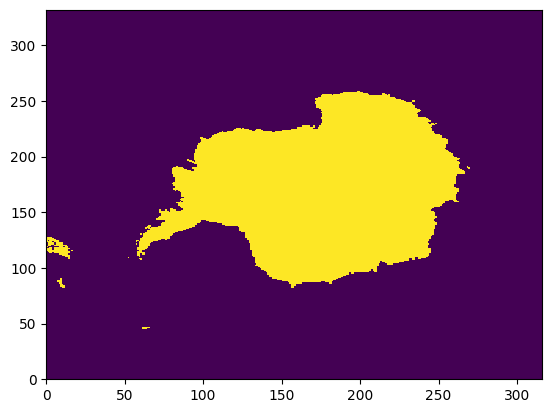

In [5]:
plt.pcolormesh(land_mask.values)

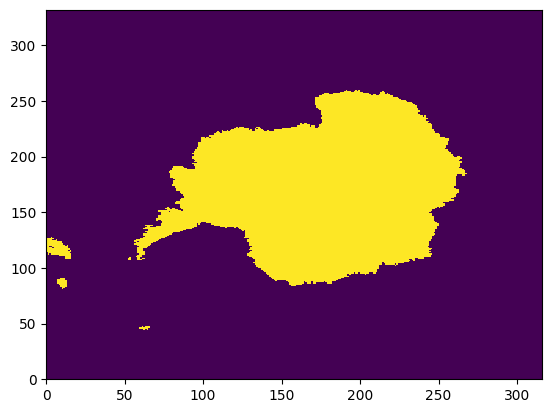

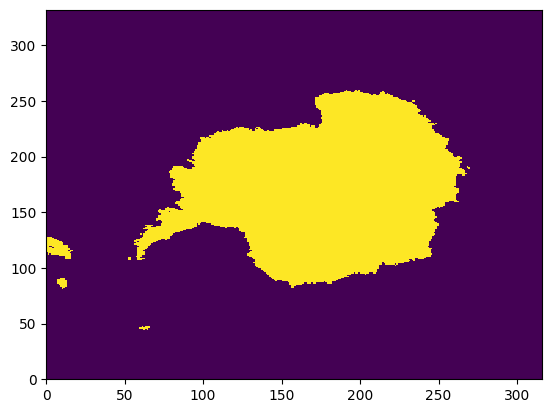

In [7]:
sst = xr.open_dataset(f"{DATA_DIRECTORY}/ERA5/sea_surface_temperature_SPS.nc").sst
land_mask_from_sst = np.isnan(sst.isel(time=0)).values

plt.pcolormesh(land_mask_from_sst)
plt.show()
plt.pcolormesh(np.logical_or(land_mask_from_sst, land_mask))

In [21]:
start_prediction_months = [pd.Timestamp("2000-01"), pd.Timestamp("2000-02")]

# params for problem definition 

# how many months into the future to predict 
max_month_lead_time = 6 

# input variable params  
input_config = {
    'siconc': {
        'plevel': None,
        'short_name': 'siconc',
        'include': True,
        'anom': False,
        'land_mask': True,
        'lag': 12
    },
    'siconc_linear_forecast': {
        'plevel': None,
        'short_name': 'siconc',
        'include': True,
        'anom': False,
        'land_mask': True,
        'lag': None
    },
    '10m_u_component_of_wind': {
        'plevel': None,
        'short_name': 'u10',
        'include': True,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    '10m_v_component_of_wind': {
        'plevel': None,
        'short_name': 'v10',
        'include': True,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    '2m_temperature': {
        'plevel': None,
        'short_name': 't2m',
        'include': True,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'mean_sea_level_pressure': {
        'plevel': None,
        'short_name': 'msl',
        'include': True,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'sea_surface_temperature': {
        'plevel': None,
        'short_name': 'sst',
        'include': True,
        'anom': True,
        'land_mask': True,
        'lag': 9
    }, 
    'surface_net_solar_radiation': {
        'plevel': None,
        'short_name': 'ssr',
        'include': True,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'surface_net_thermal_radiation': {
        'plevel': None,
        'short_name': 'str',
        'include': True,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }, 
    'geopotential': {
        'plevel': '500',
        'short_name': 'z',
        'include': True,
        'anom': True,
        'land_mask': False,
        'lag': 3
    }
}

data_ds = {}

for input_var, input_var_params in input_config.items():
    if input_var == 'siconc':
        data_ds[input_var] = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc").siconc
    else:
        data_ds[input_var] = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/{input_var}_norm.nc")[input_var_params['short_name']]

data_pairs = []

for start_prediction_month in start_prediction_months:
    prediction_target_months = pd.date_range(start_prediction_month, \
        start_prediction_month + pd.DateOffset(months=max_month_lead_time-1), freq="MS")

    # For each target, generate data pairs
    input_list = []
    for input_var, input_var_params in input_config.items():
        if input_var == 'siconc':
            input_data = xr.open_dataset(f"{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_all.nc").siconc 
            

        if input_var_params['include']:
            if input_var_params['anom']:
                input_data = xr.open_dataset(f"{DATA_DIRECTORY}/sicpred/normalized_inputs/{input_var}_norm.nc")[input_var_params['short_name']]
    

    target = 
    prediction_target_months
    


### Notes from previous experimentation

7/17 SST below sea ice has very very small standard deviations ($\sigma \sim \mathcal{O}(0.0001)$) since it is in equilibrium with the sea ice. So $(x - \mu)/\sigma$ is a small number over a small number. Normalized values don't really make too much physical sense.

One option is to set a threshold minimum bound for $x - \mu$ for SST only, and set the normalized value to 0 (since we expect SST under sea ice to be $\approx T_f$)

Edit:
7/18: set threshold value for $\sigma$. See util.py